In [1]:
PYTHON_PATHS = ["..", "/home/mikhail/research/d2-net/lib", "/home/mikhail/research/d2-net"]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)

In [2]:
from unsupkeypoints.data.d2_net_feature_extractor import D2NetFeatureExtractor
from unsupkeypoints.data.super_point_feature_extractor import SuperPointFeatureExtractor
from unsupkeypoints.data.kapture_data import KaptureData
from unsupkeypoints.data.nn_feature_matching import NNFeatureMatching
from unsupkeypoints.data.colmap_reconstructor import ColmapReconstructor

In [3]:
import numpy as np

In [4]:
import os

# Making kapture data

In [5]:
ROOT_PATH = os.path.dirname(os.getcwd())
MINIMAL_SCORE = 10
MINIMAL_MATCHING_SCORE = 0.7

In [30]:
MODEL_FILE = "/home/mikhail/research/d2-net/models/d2_ots.pth"
SUPER_POINT_WEIGHT_PATH = "/home/mikhail/Downloads/superpoint_v1.pth"
# OUTPUT_KAPTURE_PATH = os.path.join(ROOT_PATH, "data/output_kapture/7scenes/fire/mapping")
# OUTPUT_KAPTURE_PATH = os.path.join(ROOT_PATH, "data/output_kapture/7scenes/fire/query")
# OUTPUT_KAPTURE_PATH = os.path.join(ROOT_PATH, f"data/output_kapture/7scenes/fire/mapping_{MINIMAL_SCORE}_{MINIMAL_MATCHING_SCORE}")
# OUTPUT_KAPTURE_PATH = os.path.join(ROOT_PATH, f"data/output_kapture/7scenes/fire/query_{MINIMAL_SCORE}_{MINIMAL_MATCHING_SCORE}")
# OUTPUT_KAPTURE_PATH = os.path.join(ROOT_PATH, "data/output_kapture/7scenes/fire/mapping_superpoint")
OUTPUT_KAPTURE_PATH = os.path.join(ROOT_PATH, "data/output_kapture/7scenes/fire/query_superpoint")

# INPUT_KAPTURE_PATH = os.path.join(ROOT_PATH, "data/kapture/7scenes/fire/mapping")
INPUT_KAPTURE_PATH = os.path.join(ROOT_PATH, "data/kapture/7scenes/fire/query")

IMAGE_PATH = os.path.join("/home/mikhail/research/lie-pose-net/data/7scenes/fire/")

KAPTURE_DATA = KaptureData.load_from(INPUT_KAPTURE_PATH, OUTPUT_KAPTURE_PATH, IMAGE_PATH)
# KAPTURE_DATA = KaptureData.load_from(OUTPUT_KAPTURE_PATH, OUTPUT_KAPTURE_PATH, IMAGE_PATH)

# Feature extractor

In [31]:
# FEATURE_EXTRACTOR = D2NetFeatureExtractor(model_file=MODEL_FILE, minimal_score=MINIMAL_SCORE)
FEATURE_EXTRACTOR = SuperPointFeatureExtractor(weights_path=SUPER_POINT_WEIGHT_PATH)
FEATURE_EXTRACTOR.extract_features(KAPTURE_DATA)

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning:

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.

100%|██████████| 2000/2000 [01:21<00:00, 24.41it/s]


In [32]:
KAPTURE_DATA.save()

# Feature matching

In [33]:
FEATURE_MATCHING = NNFeatureMatching(minimal_score=MINIMAL_MATCHING_SCORE, sequential_length=100)
FEATURE_MATCHING.match_features(KAPTURE_DATA)

100%|██████████| 2000/2000 [03:09<00:00, 10.54it/s]


In [34]:
KAPTURE_DATA.save()

# Colmap reconstruction

In [35]:
COLMAP_RECONSTRUCTION = ColmapReconstructor("tmp/colmap", "/usr/local/bin/colmap")
COLMAP_RECONSTRUCTION.reconstruct(KAPTURE_DATA)

Step 1. Remove rigs
Step 2. Kapture to colmap
Step 3. Generate priors for reconstruction
Step 4. Point triangulator
Step 5. Model converter
Step 5. Reconstruction import


In [36]:
KAPTURE_DATA.save()

# Load reconstruction

In [37]:
import plotly.graph_objects as go

In [38]:
positions = np.array([y["kinect_rgb"].t for x, y in KAPTURE_DATA.trajectories.items()])[:, :, 0]

In [39]:
points = np.array(KAPTURE_DATA.points3d)
print(len(points))
mask = [len(KAPTURE_DATA.observations[x]) > 10 for x in KAPTURE_DATA.observations]
show_points = points[mask]
print(len(show_points))

69898
29678


In [40]:
# mask = np.linalg.norm(points[:, :3], axis=1) < 30
mask = [len(KAPTURE_DATA.observations[x]) > 10 for x in KAPTURE_DATA.observations]
show_points = points[mask]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=show_points[:, 0],
            y=show_points[:, 1],
            z=show_points[:, 2],
            mode='markers',
            marker=dict(
                size=1,
                color=show_points[:, 3:],
            )
        ),
        go.Scatter3d(
            x=positions[:, 0],
            y=positions[:, 1],
            z=positions[:, 2],
            mode="lines"
        )
    ]
)
fig.show()

# Rerpojection error

In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import quaternion
import cv2

In [18]:
from kapture.io.features import get_descriptors_fullpath, get_keypoints_fullpath, \
    image_descriptors_from_file, image_keypoints_from_file
import kapture
from sys import getsizeof

In [19]:
IMAGE_PATH = "/home/mikhail/research/lie-pose-net/data/7scenes/fire/seq-01/frame-000001.color.png"
IMAGE_NAME = "seq-01/frame-000001.color.png"

# IMAGE_PATH = "/home/mikhail/research/lie-pose-net/data/7scenes/fire/seq-03/frame-000001.color.png"
# IMAGE_NAME = "seq-03/frame-000001.color.png"

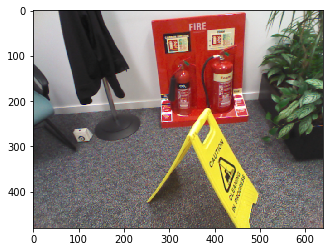

In [20]:
INPUT_IMAGE = np.asarray(Image.open(IMAGE_PATH))
plt.imshow(INPUT_IMAGE)

In [21]:
keypoints_fullpath = get_keypoints_fullpath(KAPTURE_DATA.kapture_path, IMAGE_NAME)
keypoints = image_keypoints_from_file(keypoints_fullpath, KAPTURE_DATA.keypoints.dtype, 
                                      KAPTURE_DATA.keypoints.dsize)

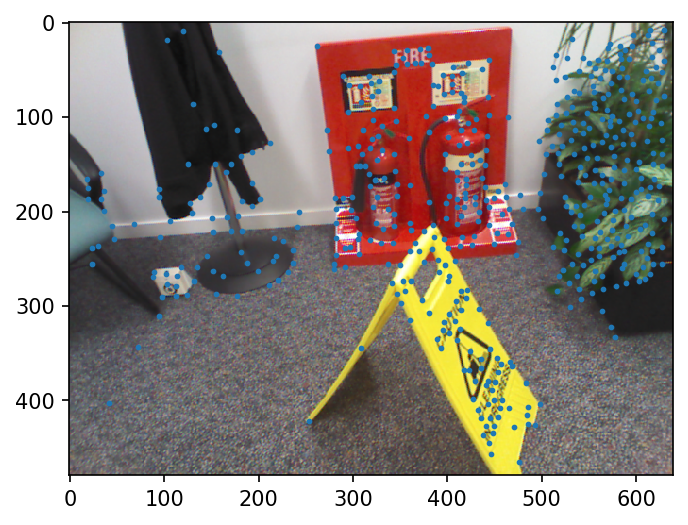

In [22]:
plt.figure(dpi=150)
plt.imshow(INPUT_IMAGE)
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=3)

In [23]:
keypoints3d = np.zeros((len(keypoints), 3), dtype=np.float32)
keypoint_mask = np.zeros(len(keypoints), dtype=np.bool)
for point_index, observation in KAPTURE_DATA.observations.items():
    for image_name, image_keypoints_index in observation:
        if image_name == IMAGE_NAME:
            keypoint_mask[image_keypoints_index] = True
            keypoints3d[image_keypoints_index] = KAPTURE_DATA.points3d[point_index][:3]

In [24]:
def matrix_from_position(position):
    matrix = np.zeros((4, 4), dtype=np.float32)
    rotation = quaternion.as_rotation_matrix(position.r)
    matrix[:3, :3] = rotation
    matrix[:3, 3] = np.array(position.t[:, 0])
    matrix[3, 3] = 1
    return matrix

In [26]:
POSITION = matrix_from_position(KAPTURE_DATA.trajectories[0]["kinect_rgb"])
# POSITION = np.linalg.inv(POSITION)
# np.linalg.inv(POSITION)

In [27]:
camera_keypoints3d = (POSITION[:3, :3] @ keypoints3d.T).T + POSITION[:3, 3]
camera_keypoints3d[0]

array([0.30049363, 0.26335308, 1.20207   ], dtype=float32)

In [28]:
sensor_parameters = np.array([640, 480, 525, 320, 240])
projected_keypoints = np.zeros((len(keypoints), 2), dtype=np.float32)
projected_keypoints[:, 0] = sensor_parameters[3] + \
    sensor_parameters[2] * camera_keypoints3d[:, 0] / camera_keypoints3d[:, 2]
projected_keypoints[:, 1] = sensor_parameters[4] + \
    sensor_parameters[2] * camera_keypoints3d[:, 1] / camera_keypoints3d[:, 2]

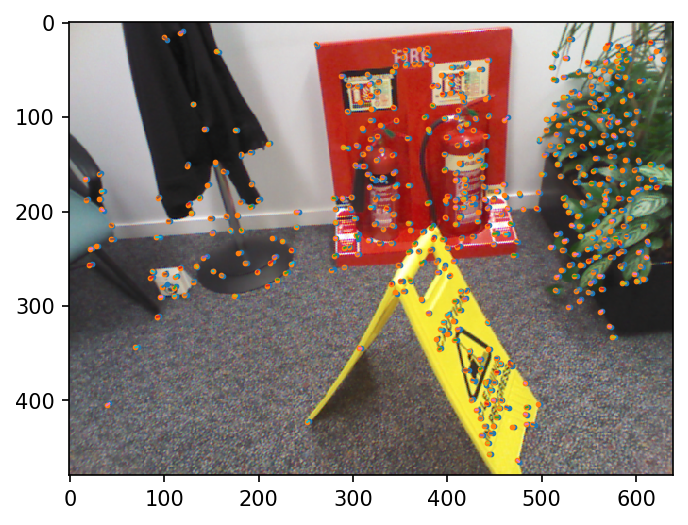

In [29]:
plt.figure(dpi=150)
plt.imshow(INPUT_IMAGE)
mask = keypoint_mask
plt.scatter(keypoints[mask, 0], keypoints[mask, 1], s=3)
plt.scatter(projected_keypoints[mask, 0], projected_keypoints[mask, 1], s=3)
for i in range(len(keypoints)):
    if mask[i]:
        plt.plot([keypoints[i, 0], projected_keypoints[i, 0]], 
                 [keypoints[i, 1], projected_keypoints[i, 1]], linewidth=1)